### Necessary Imports

In [1]:
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
sys.path.append(os.path.abspath(os.path.join('..', '..', 'models', 'AutoEncoders')))
from cnn_autoencoder import CNNAutoencoder


import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### Loading and splitting the Fashion MNIST dataset

In [2]:
base_path = '../../data/external/fashion_mnist'
train_path = f'{base_path}/fashion-mnist_train.csv'
test_path = f'{base_path}/fashion-mnist_test.csv'
output_path = '../../data/interim/4/fashion_mnist'

train_df = pd.read_csv(train_path)
test_df = pd.read_csv(test_path)

train_df = train_df.sample(frac=1, random_state=42).reset_index(drop=True)

train_df_split = train_df[:50000]
val_df_split = train_df[50000:]

train_df_split.to_csv(f'{output_path}/fashion-mnist_train.csv', index=False)
val_df_split.to_csv(f'{output_path}/fashion-mnist_val.csv', index=False)
test_df.to_csv(f'{output_path}/fashion-mnist_test.csv', index=False)

print("Data shuffled, split, and saved successfully.")


Data shuffled, split, and saved successfully.


#### Visualizing images from the dataset to see different kinds of clothings and the labels assigned to them

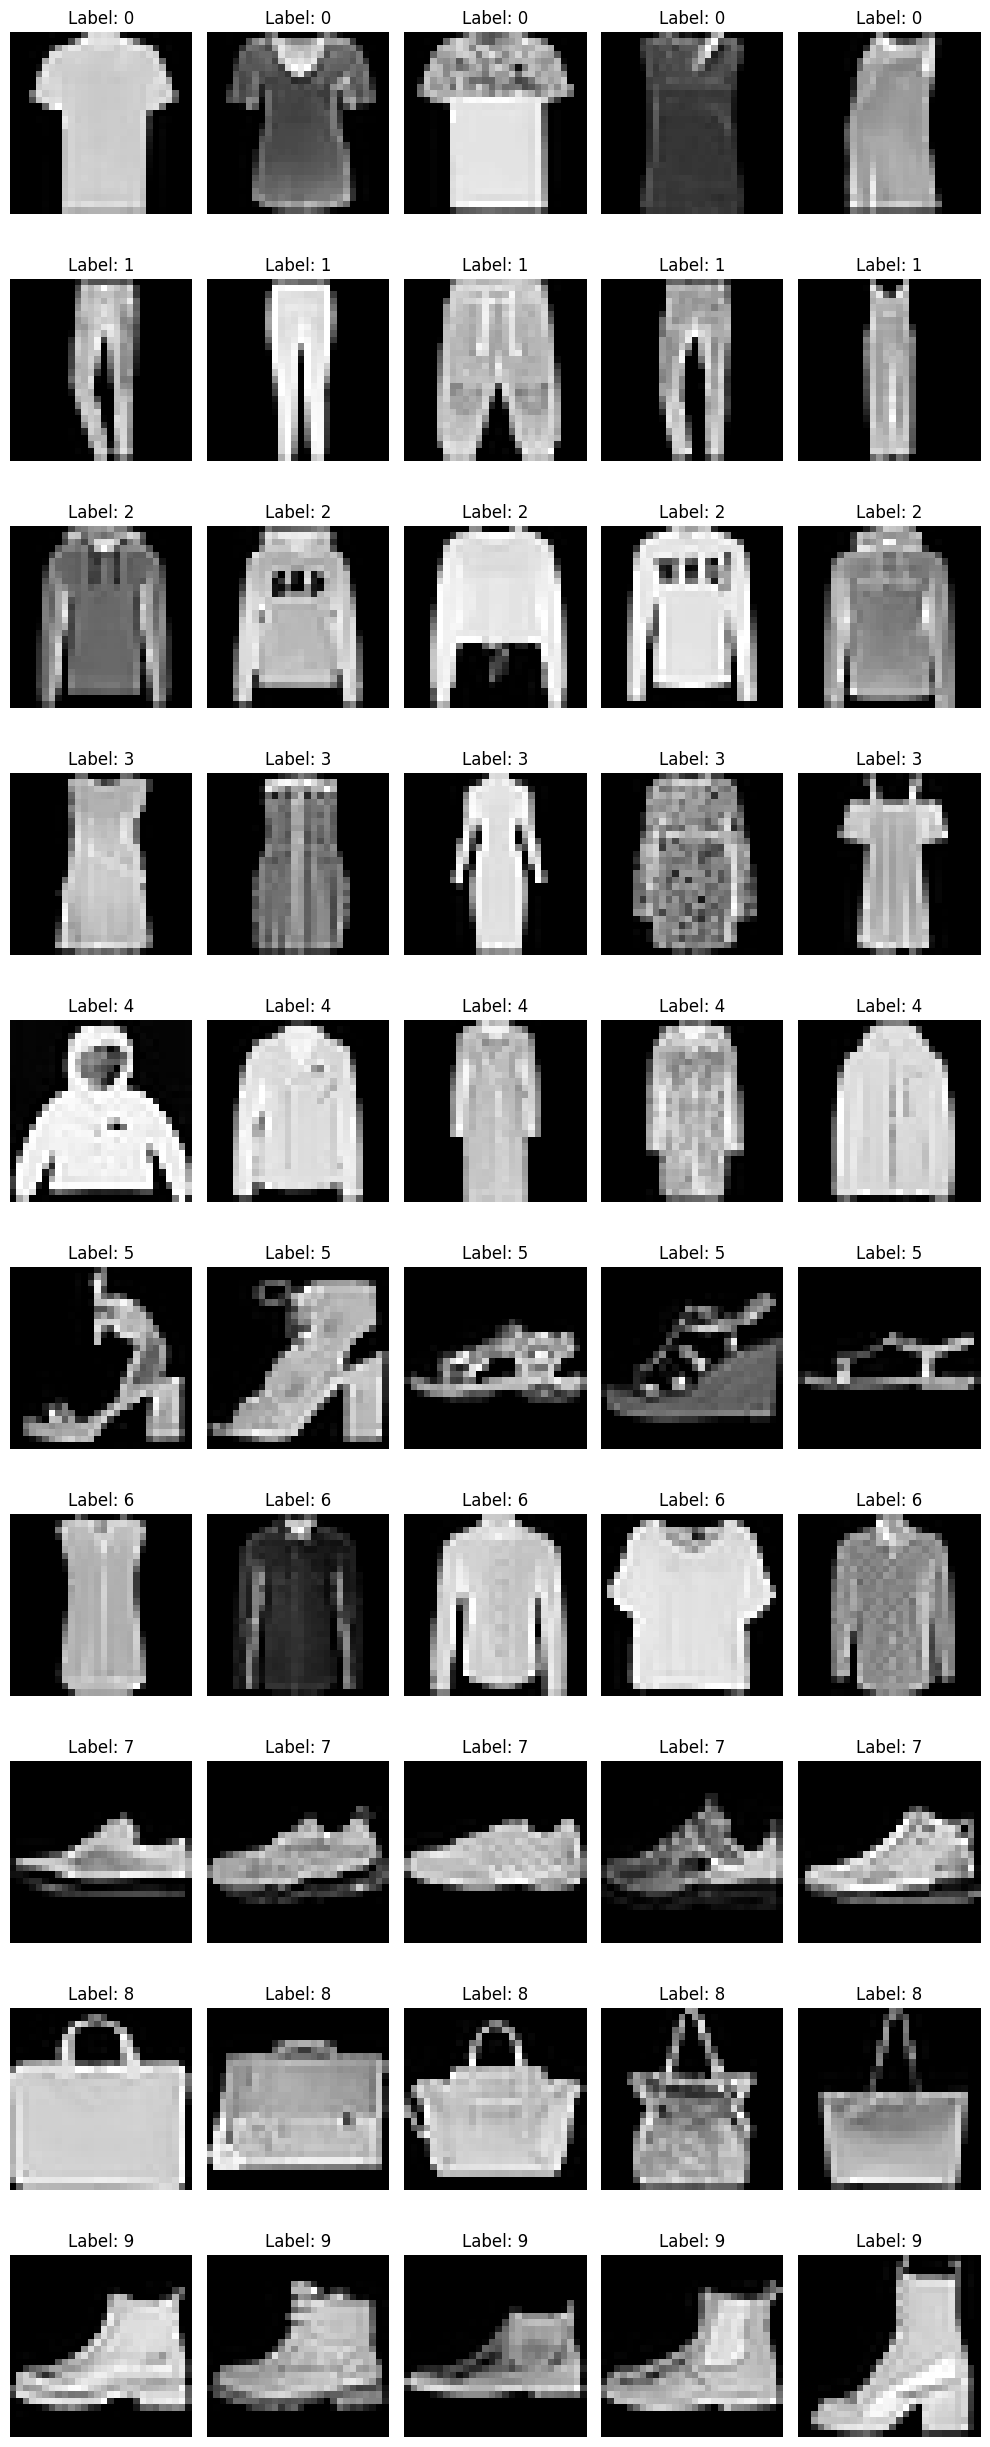

In [3]:
num_labels = 10 
fig, axes = plt.subplots(num_labels, 5, figsize=(10, num_labels * 2.5))

for label in range(num_labels):
    images = train_df[train_df.iloc[:, 0] == label].iloc[:, 1:].values[:5] 
    for j, image in enumerate(images):
        image_reshaped = image.reshape(28, 28)
        axes[label, j].imshow(image_reshaped, cmap='gray')
        axes[label, j].set_title(f'Label: {label}')
        axes[label, j].axis('off')
plt.tight_layout()
plt.show()

#### Listing the clothing type represented by each class

0. **T-shirt**

1. **Trousers**

2. **Sweater**: This looks like warm clothing, mostly without a zipper.

3. **Dress**

4. **Jackets**: This looks like warm clothing, with what seems like zippers in most cases.

5. **Sandals**: The images shows open footwear, like heels and wedges.

6. **Shirts/Polos**: This looks like a collared shirt with buttons down the front.

7. **Sneakers**: These appear to be athletic shoes.

8. **Bag**: These resemble purses or handbags.

9. **Boots**: These look like footwear but are higher than the sneakers.

### Loading the data

In [3]:
base_path = '../../data/interim/4/fashion_mnist'
train_path = f'{base_path}/fashion-mnist_train.csv'
val_path = f'{base_path}/fashion-mnist_val.csv'
test_path = f'{base_path}/fashion-mnist_test.csv'

def load_fashion_data():
    train_df = pd.read_csv(train_path)
    val_df = pd.read_csv(val_path)
    test_df = pd.read_csv(test_path)

    X_train = train_df.iloc[:, 1:].values.astype('float32') / 255.0 
    y_train = train_df.iloc[:, 0].values  
    
    X_val = val_df.iloc[:, 1:].values.astype('float32') / 255.0 
    y_val = val_df.iloc[:, 0].values  
    
    X_test = test_df.iloc[:, 1:].values.astype('float32') / 255.0 
    y_test = test_df.iloc[:, 0].values  
    
    return (train_df, val_df, test_df), (X_train, y_train, X_val, y_val, X_test, y_test)

class MultiMNISTDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        label = self.dataframe.iloc[idx, 0]
        image = self.dataframe.iloc[idx, 1:].values.astype('uint8').reshape(28, 28)  
        image = Image.fromarray(image)  
        if self.transform:
            image = self.transform(image)
        
        return image, label

(dataframes, (X_train, y_train, X_val, y_val, X_test, y_test)) = load_fashion_data()

transform = transforms.Compose([
    transforms.ToTensor(), 
])

batch_size = 32
train_dataset = MultiMNISTDataset(dataframes[0], transform=transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

val_dataset = MultiMNISTDataset(dataframes[1], transform=transform)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

test_dataset = MultiMNISTDataset(dataframes[2], transform=transform)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

### Implementing the CnnAutoencoder class

In [5]:
model = CNNAutoencoder(device=device).to(device)
model.fit(train_loader, num_epochs=1, learning_rate=0.001)
model.evaluate(test_loader)

Epoch [1/1]: 100%|██████████| 1563/1563 [00:34<00:00, 44.66batch/s]


Epoch [1/1], Loss: 0.0263


Evaluating: 100%|██████████| 313/313 [00:03<00:00, 82.98batch/s] 

Test Loss: 0.0124


0.012439010725915432

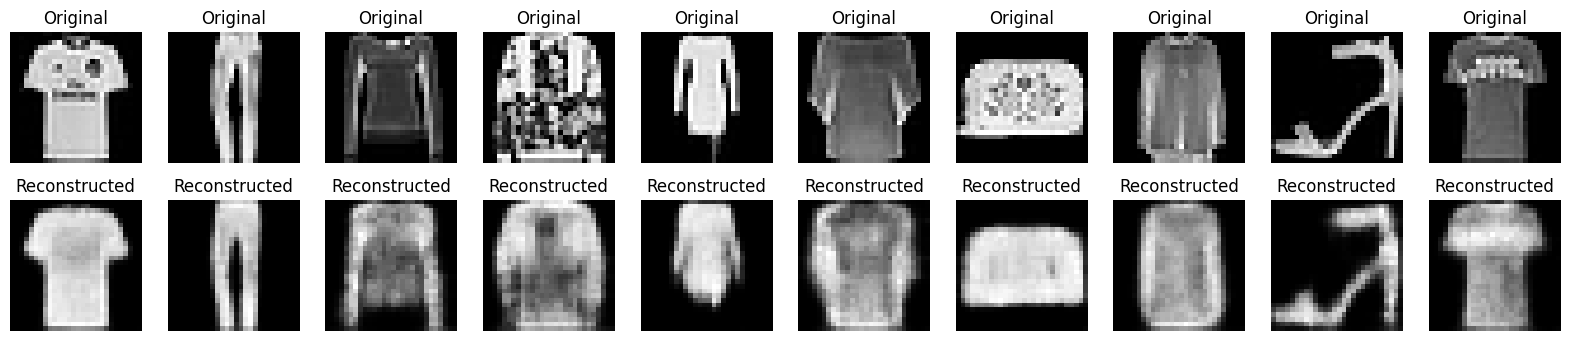

In [6]:
import matplotlib.pyplot as plt

def show_reconstructed_images(model, data_loader, num_images=10):
    model.eval()
    
    data_iter = iter(data_loader)
    images, _ = next(data_iter)
    images = images[:num_images]  
    images = images.to(device)
    
    with torch.no_grad():
        reconstructed = model(images)

    images = images.cpu()
    reconstructed = reconstructed.cpu()
    
    fig, axes = plt.subplots(2, num_images, figsize=(20, 4))
    for i in range(num_images):
        axes[0, i].imshow(images[i].squeeze(), cmap='gray')
        axes[0, i].set_title("Original")
        axes[0, i].axis('off')
        axes[1, i].imshow(reconstructed[i].squeeze(), cmap='gray')
        axes[1, i].set_title("Reconstructed")
        axes[1, i].axis('off')
    
    plt.show()

show_reconstructed_images(model, test_loader, num_images=10)


#### Autoencoder Output Quality:
The reconstructed images show good preservation of basic clothing shapes and silhouettes while losing finer details. Essential structural elements like collars, sleeves, and pant legs remain identifiable, but text patterns and textures are notably smoothed out. This level of reconstruction is sufficient for distinguishing clothing categories while demonstrating expected information compression in the latent space.

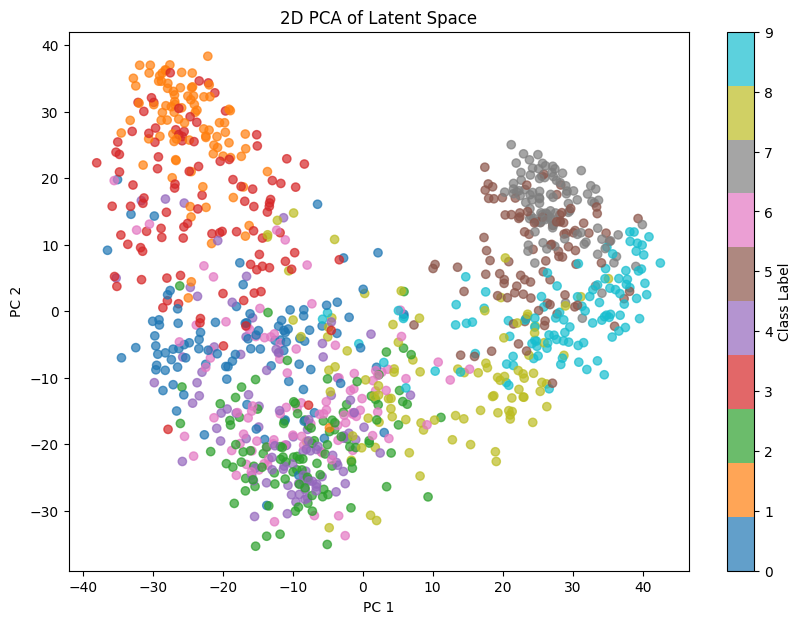

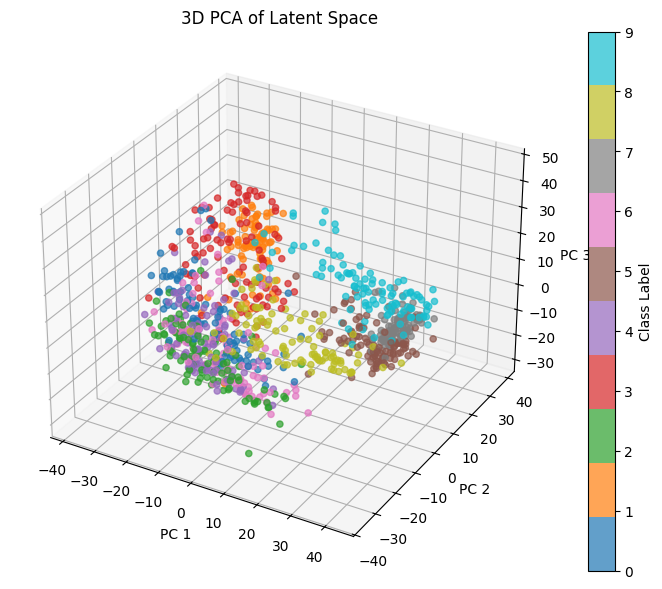

In [7]:
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D

def plot_latent_space(model, data_loader, num_samples=1000):
    model.eval()
    latent_representations = []
    labels = []
    
    with torch.no_grad():
        for x, y in data_loader:
            x = x.to(device)
            encoded = model.encode(x)
            latent_representations.append(encoded.view(encoded.size(0), -1).cpu().numpy())
            labels.extend(y.cpu().numpy())
            if len(labels) >= num_samples:
                break
    
    latent_representations = np.concatenate(latent_representations)[:num_samples]
    labels = np.array(labels)[:num_samples]
    
    pca_2d = PCA(n_components=2)
    latent_2d = pca_2d.fit_transform(latent_representations)
    
    pca_3d = PCA(n_components=3)
    latent_3d = pca_3d.fit_transform(latent_representations)

    # 2D plot
    plt.figure(figsize=(10, 7))
    scatter = plt.scatter(latent_2d[:, 0], latent_2d[:, 1], c=labels, cmap='tab10', alpha=0.7)
    plt.colorbar(scatter, label='Class Label')
    plt.xlabel("PC 1")
    plt.ylabel("PC 2")
    plt.title("2D PCA of Latent Space")
    plt.show()

    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(111, projection='3d')
    scatter = ax.scatter(latent_3d[:, 0], latent_3d[:, 1], latent_3d[:, 2], c=labels, cmap='tab10', alpha=0.7)
    fig.colorbar(scatter, ax=ax, label='Class Label')
    ax.set_xlabel("PC 1")
    ax.set_ylabel("PC 2")
    ax.set_zlabel("PC 3")
    plt.title("3D PCA of Latent Space")
    plt.show()

plot_latent_space(model, test_loader)


### Latent Space Analysis:

The PCA visualizations indicate notable clustering of fashion items:

- Footwear items, such as Sandals, Boots and Sneakers, are grouped closely, reflecting their functional similarities.Sandls and Sneakers have overlaps in the 3D space.
- Full-body garments like Jackets and Sweaters are also positioned near each other.
- Bags are distinctly clustered.
- A clear clustering can be seen between clothing items, footwear and bgs.
- There is a proximity between Trousers and Dresses, possibly due to both being full-length items, but th clusters are distinct enough.

### Hyperparameter Tuning

Training model 1/4 with params: {'learning_rate': 0.001, 'kernel_sizes': [3, 3, 7], 'num_filters': [16, 32, 64], 'optimizer': 'adam'}


Epoch [1/10]: 100%|██████████| 782/782 [00:18<00:00, 43.18batch/s]


Epoch [1/10], Loss: 0.0343


Evaluating: 100%|██████████| 157/157 [00:02<00:00, 68.40batch/s]


Validation Loss: 0.0153


Epoch [2/10]: 100%|██████████| 782/782 [00:17<00:00, 44.49batch/s]


Epoch [2/10], Loss: 0.0127


Evaluating: 100%|██████████| 157/157 [00:01<00:00, 88.65batch/s]


Validation Loss: 0.0110


Epoch [3/10]: 100%|██████████| 782/782 [00:18<00:00, 43.43batch/s]


Epoch [3/10], Loss: 0.0100


Evaluating: 100%|██████████| 157/157 [00:02<00:00, 75.26batch/s]


Validation Loss: 0.0093


Epoch [4/10]: 100%|██████████| 782/782 [00:18<00:00, 43.00batch/s]


Epoch [4/10], Loss: 0.0087


Evaluating: 100%|██████████| 157/157 [00:02<00:00, 67.95batch/s]


Validation Loss: 0.0083


Epoch [5/10]: 100%|██████████| 782/782 [00:18<00:00, 43.10batch/s]


Epoch [5/10], Loss: 0.0079


Evaluating: 100%|██████████| 157/157 [00:02<00:00, 59.42batch/s]


Validation Loss: 0.0078


Epoch [6/10]: 100%|██████████| 782/782 [00:17<00:00, 43.96batch/s]


Epoch [6/10], Loss: 0.0074


Evaluating: 100%|██████████| 157/157 [00:02<00:00, 71.85batch/s]


Validation Loss: 0.0073


Epoch [7/10]: 100%|██████████| 782/782 [00:17<00:00, 44.34batch/s]


Epoch [7/10], Loss: 0.0070


Evaluating: 100%|██████████| 157/157 [00:02<00:00, 66.37batch/s]


Validation Loss: 0.0070


Epoch [8/10]: 100%|██████████| 782/782 [00:18<00:00, 41.84batch/s]


Epoch [8/10], Loss: 0.0068


Evaluating: 100%|██████████| 157/157 [00:02<00:00, 78.08batch/s]


Validation Loss: 0.0069


Epoch [9/10]: 100%|██████████| 782/782 [00:20<00:00, 38.91batch/s]


Epoch [9/10], Loss: 0.0066


Evaluating: 100%|██████████| 157/157 [00:02<00:00, 58.88batch/s]


Validation Loss: 0.0066


Epoch [10/10]: 100%|██████████| 782/782 [00:19<00:00, 39.56batch/s]


Epoch [10/10], Loss: 0.0064


Evaluating: 100%|██████████| 157/157 [00:02<00:00, 73.96batch/s]


Validation Loss: 0.0066
Training model 2/4 with params: {'learning_rate': 0.0005, 'kernel_sizes': [3, 3, 7], 'num_filters': [8, 16, 32], 'optimizer': 'adam'}


Epoch [1/10]: 100%|██████████| 782/782 [00:12<00:00, 60.21batch/s]


Epoch [1/10], Loss: 0.0625


Evaluating: 100%|██████████| 157/157 [00:02<00:00, 71.74batch/s]


Validation Loss: 0.0247


Epoch [2/10]: 100%|██████████| 782/782 [00:12<00:00, 61.57batch/s]


Epoch [2/10], Loss: 0.0208


Evaluating: 100%|██████████| 157/157 [00:02<00:00, 74.56batch/s]


Validation Loss: 0.0183


Epoch [3/10]: 100%|██████████| 782/782 [00:14<00:00, 55.75batch/s]


Epoch [3/10], Loss: 0.0170


Evaluating: 100%|██████████| 157/157 [00:01<00:00, 84.14batch/s]


Validation Loss: 0.0159


Epoch [4/10]: 100%|██████████| 782/782 [00:14<00:00, 52.51batch/s]


Epoch [4/10], Loss: 0.0151


Evaluating: 100%|██████████| 157/157 [00:02<00:00, 73.01batch/s]


Validation Loss: 0.0144


Epoch [5/10]: 100%|██████████| 782/782 [00:16<00:00, 47.15batch/s]


Epoch [5/10], Loss: 0.0139


Evaluating: 100%|██████████| 157/157 [00:02<00:00, 68.35batch/s]


Validation Loss: 0.0134


Epoch [6/10]: 100%|██████████| 782/782 [00:14<00:00, 53.95batch/s]


Epoch [6/10], Loss: 0.0130


Evaluating: 100%|██████████| 157/157 [00:01<00:00, 82.56batch/s]


Validation Loss: 0.0127


Epoch [7/10]: 100%|██████████| 782/782 [00:15<00:00, 51.08batch/s]


Epoch [7/10], Loss: 0.0124


Evaluating: 100%|██████████| 157/157 [00:01<00:00, 78.87batch/s]


Validation Loss: 0.0121


Epoch [8/10]: 100%|██████████| 782/782 [00:13<00:00, 59.60batch/s]


Epoch [8/10], Loss: 0.0119


Evaluating: 100%|██████████| 157/157 [00:02<00:00, 75.72batch/s]


Validation Loss: 0.0117


Epoch [9/10]: 100%|██████████| 782/782 [00:13<00:00, 55.98batch/s]


Epoch [9/10], Loss: 0.0115


Evaluating: 100%|██████████| 157/157 [00:01<00:00, 88.89batch/s]


Validation Loss: 0.0114


Epoch [10/10]: 100%|██████████| 782/782 [00:14<00:00, 54.69batch/s]


Epoch [10/10], Loss: 0.0112


Evaluating: 100%|██████████| 157/157 [00:02<00:00, 59.62batch/s]


Validation Loss: 0.0111
Training model 3/4 with params: {'learning_rate': 0.001, 'kernel_sizes': [3, 3, 3], 'num_filters': [8, 16, 32], 'optimizer': 'sgd'}


Epoch [1/10]: 100%|██████████| 782/782 [00:13<00:00, 57.88batch/s]


Epoch [1/10], Loss: 0.2015


Evaluating: 100%|██████████| 157/157 [00:02<00:00, 64.59batch/s]


Validation Loss: 0.1940


Epoch [2/10]: 100%|██████████| 782/782 [00:13<00:00, 59.76batch/s]


Epoch [2/10], Loss: 0.1877


Evaluating: 100%|██████████| 157/157 [00:01<00:00, 82.04batch/s] 


Validation Loss: 0.1814


Epoch [3/10]: 100%|██████████| 782/782 [00:12<00:00, 61.00batch/s]


Epoch [3/10], Loss: 0.1763


Evaluating: 100%|██████████| 157/157 [00:01<00:00, 114.73batch/s]


Validation Loss: 0.1710


Epoch [4/10]: 100%|██████████| 782/782 [00:12<00:00, 60.57batch/s]


Epoch [4/10], Loss: 0.1669


Evaluating: 100%|██████████| 157/157 [00:01<00:00, 88.30batch/s] 


Validation Loss: 0.1625


Epoch [5/10]: 100%|██████████| 782/782 [00:12<00:00, 64.44batch/s]


Epoch [5/10], Loss: 0.1592


Evaluating: 100%|██████████| 157/157 [00:02<00:00, 59.71batch/s]


Validation Loss: 0.1556


Epoch [6/10]: 100%|██████████| 782/782 [00:15<00:00, 50.84batch/s]


Epoch [6/10], Loss: 0.1530


Evaluating: 100%|██████████| 157/157 [00:02<00:00, 63.37batch/s]


Validation Loss: 0.1500


Epoch [7/10]: 100%|██████████| 782/782 [00:12<00:00, 61.99batch/s]


Epoch [7/10], Loss: 0.1480


Evaluating: 100%|██████████| 157/157 [00:02<00:00, 73.66batch/s]


Validation Loss: 0.1455


Epoch [8/10]: 100%|██████████| 782/782 [00:13<00:00, 58.08batch/s]


Epoch [8/10], Loss: 0.1439


Evaluating: 100%|██████████| 157/157 [00:01<00:00, 92.93batch/s]


Validation Loss: 0.1418


Epoch [9/10]: 100%|██████████| 782/782 [00:10<00:00, 73.57batch/s]


Epoch [9/10], Loss: 0.1406


Evaluating: 100%|██████████| 157/157 [00:02<00:00, 75.34batch/s]


Validation Loss: 0.1388


Epoch [10/10]: 100%|██████████| 782/782 [00:14<00:00, 54.63batch/s]


Epoch [10/10], Loss: 0.1379


Evaluating: 100%|██████████| 157/157 [00:02<00:00, 61.80batch/s]


Validation Loss: 0.1363
Training model 4/4 with params: {'learning_rate': 0.0025, 'kernel_sizes': [7, 3, 3], 'num_filters': [32, 64, 32], 'optimizer': 'sgd'}


Epoch [1/10]: 100%|██████████| 782/782 [00:22<00:00, 35.39batch/s]


Epoch [1/10], Loss: 0.1521


Evaluating: 100%|██████████| 157/157 [00:02<00:00, 62.39batch/s]


Validation Loss: 0.1456


Epoch [2/10]: 100%|██████████| 782/782 [00:20<00:00, 38.61batch/s]


Epoch [2/10], Loss: 0.1416


Evaluating: 100%|██████████| 157/157 [00:02<00:00, 69.58batch/s]


Validation Loss: 0.1376


Epoch [3/10]: 100%|██████████| 782/782 [00:17<00:00, 45.17batch/s]


Epoch [3/10], Loss: 0.1354


Evaluating: 100%|██████████| 157/157 [00:02<00:00, 76.74batch/s]


Validation Loss: 0.1328


Epoch [4/10]: 100%|██████████| 782/782 [00:17<00:00, 44.35batch/s]


Epoch [4/10], Loss: 0.1317


Evaluating: 100%|██████████| 157/157 [00:02<00:00, 65.22batch/s]


Validation Loss: 0.1299


Epoch [5/10]: 100%|██████████| 782/782 [00:17<00:00, 43.48batch/s]


Epoch [5/10], Loss: 0.1294


Evaluating: 100%|██████████| 157/157 [00:02<00:00, 69.78batch/s]


Validation Loss: 0.1281


Epoch [6/10]: 100%|██████████| 782/782 [00:17<00:00, 43.45batch/s]


Epoch [6/10], Loss: 0.1279


Evaluating: 100%|██████████| 157/157 [00:02<00:00, 68.52batch/s]


Validation Loss: 0.1268


Epoch [7/10]: 100%|██████████| 782/782 [00:18<00:00, 42.74batch/s]


Epoch [7/10], Loss: 0.1269


Evaluating: 100%|██████████| 157/157 [00:03<00:00, 50.47batch/s]


Validation Loss: 0.1260


Epoch [8/10]: 100%|██████████| 782/782 [00:17<00:00, 45.88batch/s]


Epoch [8/10], Loss: 0.1262


Evaluating: 100%|██████████| 157/157 [00:02<00:00, 78.00batch/s]


Validation Loss: 0.1254


Epoch [9/10]: 100%|██████████| 782/782 [00:18<00:00, 43.02batch/s]


Epoch [9/10], Loss: 0.1256


Evaluating: 100%|██████████| 157/157 [00:02<00:00, 54.33batch/s]


Validation Loss: 0.1250


Epoch [10/10]: 100%|██████████| 782/782 [00:23<00:00, 33.81batch/s]


Epoch [10/10], Loss: 0.1253


Evaluating: 100%|██████████| 157/157 [00:03<00:00, 47.93batch/s]


Validation Loss: 0.1246
Best validation loss: 0.0066


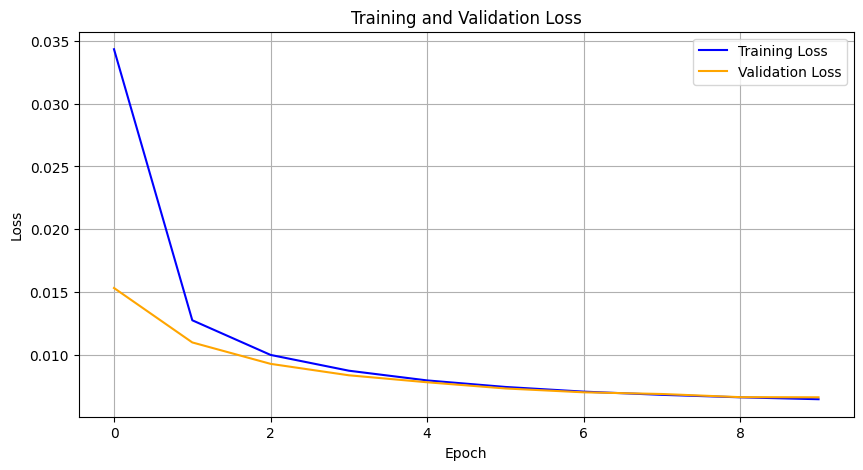

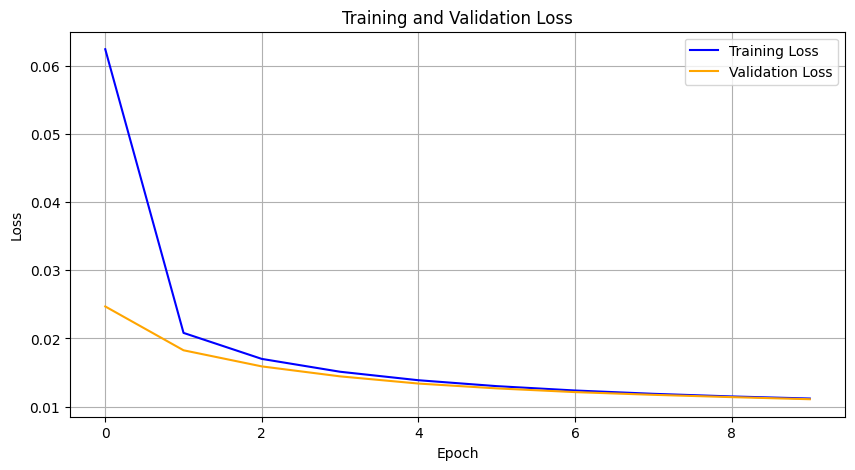

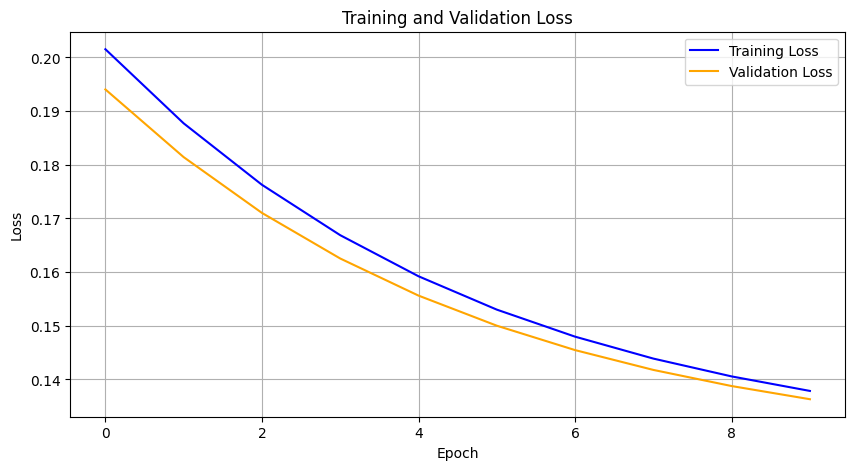

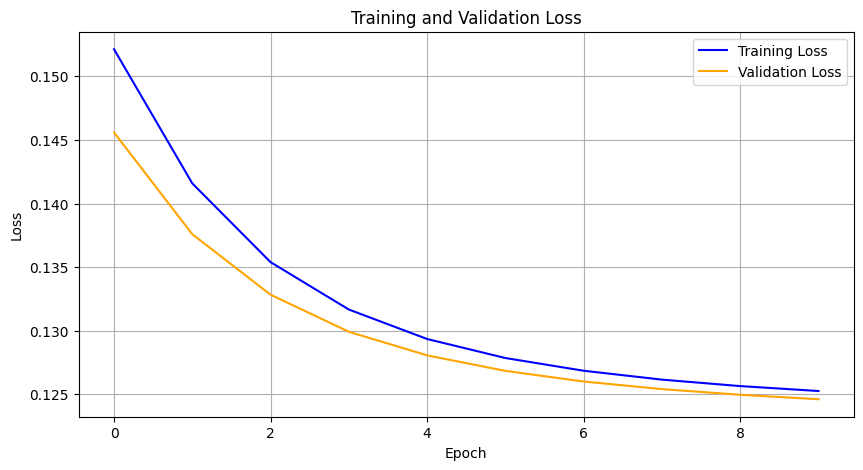

In [20]:
import os

hyperparams = [
    {'learning_rate': 0.001, 'kernel_sizes': [3, 3, 7], 'num_filters': [16, 32, 64], 'optimizer': 'adam'},
    {'learning_rate': 0.0005, 'kernel_sizes': [3, 3, 7], 'num_filters': [8, 16, 32], 'optimizer': 'adam'},
    {'learning_rate': 0.001, 'kernel_sizes': [3, 3, 3], 'num_filters': [8, 16, 32], 'optimizer': 'sgd'},
    {'learning_rate': 0.0025, 'kernel_sizes': [7, 3, 3], 'num_filters': [32, 64, 32], 'optimizer': 'sgd'},
]

os.makedirs('figures/cnn_autoencoder_loss_plots', exist_ok=True)

best_model = None
best_val_loss = float('inf')

for i, params in enumerate(hyperparams):
    print(f"Training model {i + 1}/{len(hyperparams)} with params: {params}")
    
    model = CNNAutoencoder(
        num_filters=params['num_filters'], 
        kernel_sizes=params['kernel_sizes'], 
        activation=nn.ReLU, 
        device=device,
        save_path=f'figures/cnn_autoencoder_loss_plots/model_lr{params["learning_rate"]}_ks{params["kernel_sizes"]}_nf{params["num_filters"]}_opt{params["optimizer"]}.png'
    ).to(device)

    model.fit(train_loader, val_loader=val_loader, num_epochs=10, learning_rate=params['learning_rate'], optimizer_choice=params['optimizer'])
    
    model.plot_losses()
    
    val_loss = model.val_losses[-1] if model.val_losses else float('inf')
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model = model

print(f'Best validation loss: {best_val_loss:.4f}')


##### Best Validtion Loss: 0.0066   
##### Configuration: 
```python
 {'learning_rate': 0.001, 'kernel_sizes': [3, 3, 7], 'num_filters': [16, 32, 64], 'optimizer': 'adam'}
```

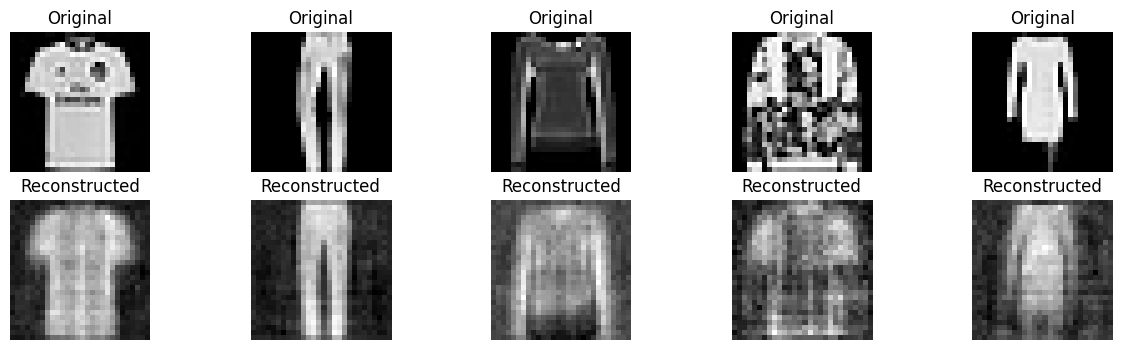

In [17]:
# from AutoEncoders import AutoEncoder


# input_size = 28*28
# latent_size = 75
# encoder_layers = []  
# decoder_layers = []  
# learning_rate = 0.08
# max_epochs = 50
# batch_size = 32

# autoencoder = AutoEncoder(
#     input_size=input_size,
#     latent_size=latent_size,
#     encoder_layers=encoder_layers,
#     decoder_layers=decoder_layers,
#     learning_rate=learning_rate,
#     optimizer='mbgd'
# )
# print(X_train.shape)
# autoencoder.fit(X_train, max_epochs=max_epochs, batch_size=batch_size)
# X_reconstructed = autoencoder.reconstruct(X_train)

import matplotlib.pyplot as plt
def visualize_reconstruction(autoencoder, X_test, n_images=5):
    X_reconstructed = autoencoder.reconstruct(X_test[:n_images])

    fig, axes = plt.subplots(2, n_images, figsize=(15, 4))
    for i in range(n_images):
        axes[0, i].imshow(X_test[i].reshape(28, 28), cmap='gray')
        axes[0, i].set_title("Original")
        axes[0, i].axis('off')

        axes[1, i].imshow(X_reconstructed[i].reshape(28, 28), cmap='gray')
        axes[1, i].set_title("Reconstructed")
        axes[1, i].axis('off')
    plt.show()

visualize_reconstruction(mlp_autoencoder_knn, X_test)

In [ ]:
print(X_train[0])

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from pca_autoencoder import PcaAutoencoder

def plot_construction_loss(X_train, max_components=20):
    errors = []
    for n in range(1, max_components + 1):
        pca_autoencoder = PcaAutoencoder(n_components=n)
        pca_autoencoder.fit(X_train)
        error = pca_autoencoder.reconstruction_error(X_train)
        errors.append(error)

    plt.plot(range(1, max_components + 1), errors, marker='o')
    plt.xlabel('Number of Components')
    plt.ylabel('Reconstruction Error')
    plt.title('Reconstruction Error vs Number of Components')
    plt.grid(True)
    plt.show()
    return errors

errors = plot_construction_loss(X_train)


In [ ]:

pca_autoencoder = PcaAutoencoder(n_components=75)
pca_autoencoder.fit(X_train)

def visualize_reconstruction(autoencoder, X_test, n_images=5):
    X_reconstructed = autoencoder.forward(X_test[:n_images])

    fig, axes = plt.subplots(2, n_images, figsize=(15, 4))
    for i in range(n_images):
        axes[0, i].imshow(X_test[i].reshape(28, 28), cmap='gray')
        axes[0, i].set_title("Original")
        axes[0, i].axis('off')

        axes[1, i].imshow(X_reconstructed[i].reshape(28, 28), cmap='gray')
        axes[1, i].set_title("Reconstructed")
        axes[1, i].axis('off')
    plt.show()

visualize_reconstruction(pca_autoencoder, X_val)

#### KNN Classification

In [8]:
import sys, os
sys.path.append(os.path.abspath(os.path.join('..', '..', 'models', 'knn')))
sys.path.append(os.path.abspath(os.path.join('..', '..', 'performance_measures')))
from knn import KNN
from classification_metrics import Metrics
K_OPTIMAL = 75

In [13]:
def chunked_predict(model, X, chunk_size=5000):
    predictions = []
    for i in range(0, len(X), chunk_size):
        chunk = X[i:i + chunk_size]
        preds = model.predict(chunk)
        predictions.append(preds)
    return np.concatenate(predictions)


In [9]:
# ae_train_x_encoded_cnn = []
# ae_test_x_encoded_cnn = []

# model.eval()
# with torch.no_grad():
#     for x, _ in train_loader:
#         x = x.to(device)
#         encoded = model.encode(x)
#         ae_train_x_encoded_cnn.append(encoded.view(encoded.size(0), -1).cpu().numpy())

#     for x, _ in test_loader:
#         x = x.to(device)
#         encoded = model.encode(x)
#         ae_test_x_encoded_cnn.append(encoded.view(encoded.size(0), -1).cpu().numpy())

# ae_train_x_encoded_cnn = np.concatenate(ae_train_x_encoded_cnn)
# ae_test_x_encoded_cnn = np.concatenate(ae_test_x_encoded_cnn)

# knn_cnn = KNN(k=5, distance_metric='cosine')
# knn_cnn.fit(ae_train_x_encoded_cnn, y_train)
# ae_pred_cnn = knn_cnn.predict(ae_test_x_encoded_cnn[:100])
scores_cnn = Metrics(y_test[:100], ae_pred_cnn, task='classification')
accuracy_cnn = scores_cnn.accuracy()
print(f"Accuracy of KNN with CNN Autoencoder: {accuracy_cnn:.2f}")



Accuracy of KNN with CNN Autoencoder: 0.11


In [ ]:
# cnn_autoencoder = CNNAutoencoder(num_filters=[16, 32, 64], kernel_sizes=[3, 3, 7], activation=nn.ReLU)
# cnn_autoencoder.fit(train_loader, num_epochs=1)

X_train_encoded_cnn = []
X_test_encoded_cnn = []
y_train_encoded_cnn = []
y_test_encoded_cnn = []

model.eval()

with torch.no_grad():
    for x, y in train_loader: 
        x = x.to(device)
        encoded = model.encode(x)
        X_train_encoded_cnn.append(encoded.view(encoded.size(0), -1).cpu().numpy())
        y_train_encoded_cnn.append(y.numpy()) 

    for x, y in test_loader: 
        x = x.to(device)
        encoded = model.encode(x)
        X_test_encoded_cnn.append(encoded.view(encoded.size(0), -1).cpu().numpy())
        y_test_encoded_cnn.append(y.numpy()) 

# Concatenate the encoded data and labels
X_train_encoded_cnn = np.concatenate(X_train_encoded_cnn)
X_test_encoded_cnn = np.concatenate(X_test_encoded_cnn)
y_train_encoded_cnn = np.concatenate(y_train_encoded_cnn) 
y_test_encoded_cnn = np.concatenate(y_test_encoded_cnn)


2
2


In [32]:
knn_cnn = KNN(k=5, distance_metric='cosine')
knn_cnn.fit(X_train_encoded_cnn, y_train)

y_pred_cnn = chunked_predict(knn_cnn,X_test_encoded_cnn)
# y_pred_cnn = knn_cnn.predict(X_test_encoded_cnn[:100])

scores_cnn = Metrics(y_test_encoded_cnn, y_pred_cnn, task='classification')
accuracy_cnn = scores_cnn.accuracy()
print(f"Accuracy of KNN with CNN Autoencoder: {accuracy_cnn:.5f}")

Accuracy of KNN with CNN Autoencoder: 0.10590


In [16]:
from pca_autoencoder import PcaAutoencoder
pca_autoencoder_knn = PcaAutoencoder(n_components=K_OPTIMAL)
pca_autoencoder_knn.fit(X_train)

X_train_encoded_pca = pca_autoencoder_knn.encode(X_train)
X_test_encoded_pca = pca_autoencoder_knn.encode(X_test)

In [17]:
print(X_test_encoded_pca)

[[ 5.45904414  1.45448497 -0.67875524 ...  0.14270776  0.76482557
  -0.15007844]
 [-0.23914062  6.1009269  -1.28390289 ... -0.20215065  0.04398976
   0.0409598 ]
 [-3.21513518  0.55932484  3.31218895 ... -0.14885302 -0.36086773
  -0.12070806]
 ...
 [ 1.08827683 -3.89161821  0.12810628 ...  0.44405606 -0.36021669
  -0.2098475 ]
 [ 6.1349816  -5.17417004 -0.15655592 ... -0.17926386  0.13355902
  -0.11450659]
 [ 7.66259568 -0.47920555  1.41153723 ...  0.20941825 -0.02762581
  -0.29454786]]


In [19]:
knn_pca = KNN(k=5, distance_metric='cosine')
knn_pca.fit(X_train_encoded_pca, y_train)
y_pred_pca = chunked_predict(knn_pca,X_test_encoded_pca)
scores_pca = Metrics(y_test, y_pred_pca, task='classification')
accuracy_pca = scores_pca.accuracy()
print(f"Accuracy of KNN with PCA: {accuracy_pca:.5f}")

: 

In [ ]:
from AutoEncoders import AutoEncoder


input_size = 28*28
latent_size = K_OPTIMAL
encoder_layers = []  
decoder_layers = []  
learning_rate = 0.01
max_epochs = 20
batch_size = 32

mlp_autoencoder_knn = AutoEncoder(
    input_size=input_size,
    latent_size=latent_size,
    encoder_layers=encoder_layers,
    decoder_layers=decoder_layers,
    learning_rate=learning_rate,
    optimizer='sgd'
)
print(X_train.shape)
mlp_autoencoder_knn.fit(X_train, max_epochs=max_epochs, batch_size=batch_size)
X_train_encoded_mlp = mlp_autoencoder_knn.get_latent(X_train)
X_test_encoded_mlp = mlp_autoencoder_knn.get_latent(X_test)

(50000, 784)
Epoch 1/20, Loss: 0.03527552569864907
Epoch 2/20, Loss: 0.020954353880839247
Epoch 3/20, Loss: 0.018760958442633813
Epoch 4/20, Loss: 0.017960207499644255
Epoch 5/20, Loss: 0.01759598351781362
Epoch 6/20, Loss: 0.017412964551129066
Epoch 7/20, Loss: 0.017316237118311067
Epoch 8/20, Loss: 0.017260665126982013
Epoch 9/20, Loss: 0.017229339568043657
Epoch 10/20, Loss: 0.017210066472636353
Epoch 11/20, Loss: 0.01719583941098912
Epoch 12/20, Loss: 0.017189918650713475
Epoch 13/20, Loss: 0.017185335510811434
Epoch 14/20, Loss: 0.017184096331290248
Epoch 15/20, Loss: 0.017180737974069386
Epoch 16/20, Loss: 0.017177516093531707
Epoch 17/20, Loss: 0.017178746523859197
Epoch 18/20, Loss: 0.01717828671556896
Epoch 19/20, Loss: 0.01717666472649562
Epoch 20/20, Loss: 0.01717654615754755


In [ ]:
knn_mlp = KNN(k=5, distance_metric='cosine')
knn_mlp.fit(X_train_encoded_mlp, y_train)
y_pred_mlp = chunked_predict(knn_mlp,X_test_encoded_mlp)

y_pred_mlp_train = chunked_predict(knn_mlp,X_train_encoded_mlp)

scores_mlp = Metrics(y_test, y_pred_mlp, task='classification')
scores_mlp_train = Metrics(y_test, y_pred_mlp, task='classification')

accuracy_mlp = scores_mlp.accuracy()
print(f"Accuracy of KNN with MLP: {accuracy_mlp:.5f}")

Accuracy of KNN with MLP: 0.84620


In [ ]:
accuracies = {
    'CNN': scores_cnn.accuracy(),
    'PCA': scores_pca.accuracy(),
    'MLP': scores_mlp.accuracy(),
}

print(accuracies)

In [ ]:
model_names = list(accuracies.keys())
accuracy_values = list(accuracies.values())

plt.figure(figsize=(8, 5))
plt.bar(model_names, accuracy_values, color=['blue', 'orange', 'green'])
plt.ylim(0, 1)
plt.ylabel('Accuracy')
plt.title('Model Accuracies')
plt.show()

In [ ]:
import seaborn as sns

confusion_cnn = scores_cnn.confusion_matrix()
confusion_pca = scores_pca.confusion_matrix()
confusion_mlp = scores_mlp.confusion_matrix()

fig, axes = plt.subplots(1, 3, figsize=(18, 5))
sns.heatmap(confusion_cnn, annot=True, fmt="d", ax=axes[0], cmap='Blues')
axes[0].set_title('Confusion Matrix - CNN')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Actual')

sns.heatmap(confusion_pca, annot=True, fmt="d", ax=axes[1], cmap='Blues')
axes[1].set_title('Confusion Matrix - PCA')
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('Actual')

sns.heatmap(confusion_mlp, annot=True, fmt="d", ax=axes[2], cmap='Blues')
axes[2].set_title('Confusion Matrix - MLP')
axes[2].set_xlabel('Predicted')
axes[2].set_ylabel('Actual')

plt.show()
